In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from hmmlearn import hmm
from scipy.io import wavfile
import IPython

np.set_printoptions(suppress=True)

In [2]:
# Reading in the wav file for the audio signals as well as the sample_rate for calculatiosn
sample_rate, sample = wavfile.read('Sugar.wav')

In [3]:
# Loading the file into librosa for the Short Time Fourier Transform of the signals
audio_data, audio_rate = librosa.load('Sugar.wav')

In [4]:
# Getting the chromgrams through Short Time Fourier Transform
chromagrams = librosa.feature.chroma_stft(audio_data, audio_rate, norm=2, hop_length=1024, n_fft=4096)

In [5]:
# Total number of samples divided by sample_rate (samples per second) = total seconds
song_duration = len(sample)/sample_rate

# Total number of frames divided by total duration of the song = x frames per second 
frames_per_second = len(chromagrams[0])/song_duration

# 1 divided by frames per second = 1 frame per x seconds
seconds_per_frame = 1/frames_per_second

In [6]:
seconds_per_frame

0.046435274838623815

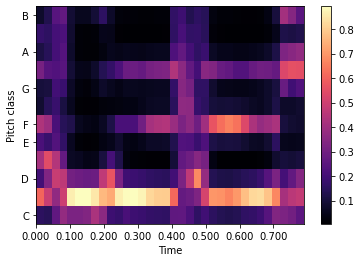

In [7]:
# Deleting the rest of the 4975 frames to visualize the initial part of the song
test = np.delete(chromagrams, np.s_[:4975], axis = 1)

# Plotting the initial 34 frames. The note played is D-flat
fig, ax = plt.subplots()
img = librosa.display.specshow(test, y_axis='chroma', x_axis='time')
plt.colorbar(img, ax=ax);

In [8]:
initial_chord_start = 0.387
final_chord_end = 232.387
seconds_per_chord = 2

In [9]:
# Calculating the first frame with sound and the last frame with sound to drop all the useless frames
first_frame_with_sound = initial_chord_start/seconds_per_frame
last_frame_with_sound = final_chord_end/seconds_per_frame - 1
print(first_frame_with_sound)
print(last_frame_with_sound)

8.334181316788548
5003.535900941965


In [10]:
# Have to prepare the emission proability matrix for the HMM
# Transposing as the current shape is number of notes x number of frames
transposed = chromagrams.T

# Dropping the frames without sound and where the chords begin
frames_with_sound = transposed[7:-14]
frames_with_sound.shape

(4988, 12)

In [11]:
total_time_elapsed = 0
summed_array = np.zeros([12])
Db_frames = []
Bbm_frames = []
Ebm_frames = []
Gb_frames = []
chord = 0
overall_chord_count = 0
frame_count = 0
stop = 0

Db = [0, 4, 8, 36, 40, 64, 68, 72]

for frame in frames_with_sound:
    total_time_elapsed += seconds_per_frame
    if chord == 0:
        if overall_chord_count in Db:
            Db_frames.append(frame)
        else:
            Gb_frames.append(frame)
    elif chord == 1:
        Bbm_frames.append(frame)
    elif chord == 2:
        Ebm_frames.append(frame)
    else:
        Db_frames.append(frame)
    frame_count += 1

    if total_time_elapsed + seconds_per_frame > seconds_per_chord:
        total_time_elapsed = 0
        overall_chord_count += 1
        if not stop:
            stop = 1
            print(frame_count)
        
        if chord == 0:
            chord += 1
        elif chord == 1:
            chord += 1
        elif chord == 2:
            chord += 1
        else:
            chord = 0

Db_frames = np.array(Db_frames)
Bbm_frames = np.array(Bbm_frames)
Ebm_frames = np.array(Ebm_frames)
Gb_frames = np.array(Gb_frames)

43


In [12]:
Db_mean = Db_frames.mean(axis=0)
Bbm_mean = Bbm_frames.mean(axis=0)
Ebm_mean = Ebm_frames.mean(axis=0)
Gb_mean = Gb_frames.mean(axis=0)
mean_chromagrams = np.vstack((Db_mean, Bbm_mean, Ebm_mean, Gb_mean))
mean_chromagrams.shape

(4, 12)

In [13]:
Db_cov_mat = np.cov(Db_frames.T)
Bbm_cov_mat = np.cov(Bbm_frames.T)
Ebm_cov_mat = np.cov(Ebm_frames.T)
Gb_cov_mat = np.cov(Gb_frames.T)
cov_matrix = np.array([Db_cov_mat, Bbm_cov_mat, Ebm_cov_mat, Gb_cov_mat])
cov_matrix.shape

(4, 12, 12)

In [14]:
init_prob_mat = np.array([1, 0, 0, 0])
init_prob_mat

array([1, 0, 0, 0])

In [15]:
trans_prob_mat = np.ones((4, 4))
trans_prob_mat = trans_prob_mat / np.sum(trans_prob_mat, axis=1).reshape((-1, 1))
trans_prob_mat

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

In [16]:
def plot_transition_matrix(A, ax=None, xlabel='State $a_j$', ylabel='State $a_i$', title='', clim=[-6, 0], cmap='gray_r'):
    im = plt.imshow(A, origin='upper', aspect='auto', cmap=cmap)
    im.set_clim([0, 1])
    cbar = plt.colorbar(im)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    cbar.ax.set_ylabel('Probability')
    
    chroma_label = ['Db', 'Bbm', 'Ebm', 'Gb']
    chord_labels = chroma_label
    
    plt.xticks(np.arange(4), labels=chroma_label )
    plt.yticks(np.arange(4), labels=chord_labels)
    return im

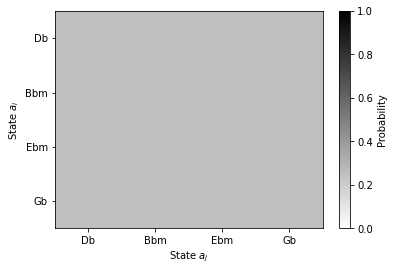

In [17]:
plot_transition_matrix(trans_prob_mat)

In [18]:
model = hmm.GaussianHMM(n_components=4, covariance_type='full',init_params='')
model.startprob_ = init_prob_mat
model.transmat_ = trans_prob_mat
model.means_ = mean_chromagrams
model.covars_ = cov_matrix

In [19]:
first_predictions = frames_with_sound[516:1032]
estimations = model.predict(first_predictions)
print(estimations)

[0 0 0 0 3 3 3 3 3 3 3 3 3 3 2 1 1 3 1 0 3 3 3 3 0 2 3 3 3 3 1 3 3 3 3 1 3
 3 3 3 3 3 3 3 3 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 2 2 3 3 1 1
 3 3 3 3 1 1 3 3 3 3 3 3 3 1 0 0 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 0 1 1 2 2 1
 2 2 2 3 3 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 0 0 0 0 0 0 1 0 0 0 0 2 2 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 3 3 3 3 3 3 3 3
 3 3 1 1 3 1 0 3 3 3 3 3 2 2 3 3 3 3 3 3 3 1 3 3 3 3 1 3 3 1 1 1 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 3 3 3 3 3 3 3 3 3 1 3 3 3 1 3 3 1 1
 1 0 0 0 1 3 2 2 2 2 2 2 2 0 1 1 1 0 2 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 0 0 0
 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 2 2 2 0 3 3 3 3 3 3 3 3 1 1 3 3 0 0 0 3 3 3 3 0
 0 0 0 3 3 3 3 3 3 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 0
 0 1 1 1 1 0 0 1 1 2 2 2 1 1 0 3 2 2 0 1 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 0 0 2 2 2 2 0 0 1 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [20]:
state_number_to_chord = {0:'Db', 1:'Bbm', 2:'Ebm', 3:'Gb'}

In [21]:
num_to_chord = []
for estimated_state in list(estimations):
    num_to_chord.append(state_number_to_chord[estimated_state])

print(num_to_chord)

['Db', 'Db', 'Db', 'Db', 'Gb', 'Gb', 'Gb', 'Gb', 'Gb', 'Gb', 'Gb', 'Gb', 'Gb', 'Gb', 'Ebm', 'Bbm', 'Bbm', 'Gb', 'Bbm', 'Db', 'Gb', 'Gb', 'Gb', 'Gb', 'Db', 'Ebm', 'Gb', 'Gb', 'Gb', 'Gb', 'Bbm', 'Gb', 'Gb', 'Gb', 'Gb', 'Bbm', 'Gb', 'Gb', 'Gb', 'Gb', 'Gb', 'Gb', 'Gb', 'Gb', 'Gb', 'Db', 'Bbm', 'Bbm', 'Bbm', 'Bbm', 'Bbm', 'Bbm', 'Bbm', 'Bbm', 'Bbm', 'Bbm', 'Bbm', 'Bbm', 'Bbm', 'Bbm', 'Bbm', 'Bbm', 'Db', 'Bbm', 'Bbm', 'Bbm', 'Bbm', 'Bbm', 'Ebm', 'Ebm', 'Gb', 'Gb', 'Bbm', 'Bbm', 'Gb', 'Gb', 'Gb', 'Gb', 'Bbm', 'Bbm', 'Gb', 'Gb', 'Gb', 'Gb', 'Gb', 'Gb', 'Gb', 'Bbm', 'Db', 'Db', 'Ebm', 'Ebm', 'Ebm', 'Ebm', 'Ebm', 'Ebm', 'Ebm', 'Ebm', 'Ebm', 'Ebm', 'Ebm', 'Bbm', 'Bbm', 'Bbm', 'Bbm', 'Db', 'Bbm', 'Bbm', 'Ebm', 'Ebm', 'Bbm', 'Ebm', 'Ebm', 'Ebm', 'Gb', 'Gb', 'Ebm', 'Ebm', 'Ebm', 'Ebm', 'Ebm', 'Db', 'Db', 'Db', 'Db', 'Db', 'Db', 'Db', 'Db', 'Db', 'Db', 'Db', 'Db', 'Db', 'Db', 'Db', 'Db', 'Db', 'Db', 'Db', 'Db', 'Db', 'Db', 'Db', 'Db', 'Db', 'Db', 'Ebm', 'Db', 'Db', 'Db', 'Db', 'Db', 'Db', 'Bbm', 'Db'

In [22]:
model.transmat_

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

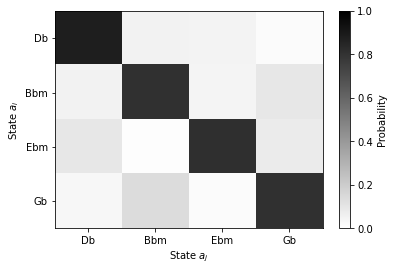

In [23]:
model.fit(first_predictions)
plot_transition_matrix(model.transmat_)

In [24]:
model.transmat_

array([[0.88163397, 0.05183486, 0.05069417, 0.015837  ],
       [0.05127894, 0.81067103, 0.04334396, 0.09470606],
       [0.0949799 , 0.01077962, 0.81457342, 0.07966706],
       [0.03371356, 0.13811739, 0.01649381, 0.81167524]])

In [25]:
estimations = model.predict(first_predictions)
print(estimations)
model.fit(first_predictions)
model.transmat_

[0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 1 1 3 1 1 3 3 3 3 0 2 2 3 3 1 1 1 3 3 3 3 3
 3 3 3 3 3 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 1 1 0 0 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1
 2 2 2 2 3 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 3 3 3 3 3 3 3 3
 3 3 1 1 3 1 1 3 3 3 3 3 2 2 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 1 1 1 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 3 3 3 3 3 3 3 3 3 3 3 3 1 1 3 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 0 0 0
 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 3 3 3 3 3 3 3 1 1 2 3 3 1 1 3 3 3 3 0
 0 0 1 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 1
 1 1 1 1 1 1 1 1 1 2 2 2 0 1 3 3 0 0 1 1 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 0 0 2 2 2 2 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

array([[0.88341071, 0.05503259, 0.04940049, 0.0121562 ],
       [0.05068785, 0.80830458, 0.04290545, 0.09810212],
       [0.09277932, 0.01143138, 0.81662062, 0.07916868],
       [0.03358637, 0.14023602, 0.01672933, 0.80944829]])

In [26]:
estimations = model.predict(first_predictions)
print(estimations)
model.fit(first_predictions)
model.transmat_

[0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 1 1 3 1 1 3 3 3 3 0 2 2 3 3 1 1 1 3 3 3 3 3
 3 3 3 3 3 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 1 1 0 0 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1
 2 2 2 2 3 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 3 3 3 3 3 3 3 3
 3 3 1 1 3 1 1 3 3 3 3 3 2 2 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 1 1 1 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 3 3 3 3 3 3 3 3 3 3 3 3 1 1 3 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 0 0 0
 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 3 3 3 3 3 3 3 1 1 2 3 3 1 1 3 3 3 3 0
 0 0 1 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 1
 1 1 1 1 1 1 1 1 1 2 2 2 0 1 3 3 0 0 1 1 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 0 0 2 2 2 2 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

array([[0.88351508, 0.05502755, 0.04930273, 0.01215464],
       [0.0506878 , 0.80831485, 0.04290757, 0.09808978],
       [0.09261804, 0.0114341 , 0.81677029, 0.07917756],
       [0.03358715, 0.14022299, 0.01672985, 0.80946001]])

[0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 1 1 3 1 1 3 3 3 3 0 2 2 3 3 1 1 1 3 3 3 3 3
 3 3 3 3 3 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 1 1 0 0 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1
 2 2 2 2 3 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 3 3 3 3 3 3 3 3
 3 3 1 1 3 1 1 3 3 3 3 3 2 2 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 1 1 1 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 3 3 3 3 3 3 3 3 3 3 3 3 1 1 3 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 0 0 0
 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 3 3 3 3 3 3 3 1 1 2 3 3 1 1 3 3 3 3 0
 0 0 1 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 1
 1 1 1 1 1 1 1 1 1 2 2 2 0 1 3 3 0 0 1 1 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 0 0 2 2 2 2 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

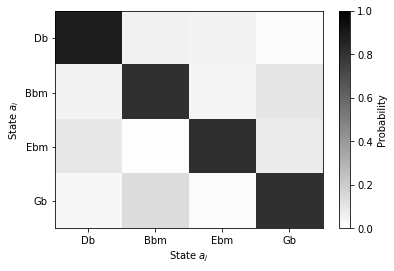

In [27]:
estimations = model.predict(first_predictions)
print(estimations)
model.fit(first_predictions)
plot_transition_matrix(model.transmat_)

In [28]:
model.transmat_

array([[0.88354231, 0.05502612, 0.04927722, 0.01215434],
       [0.05068731, 0.80831821, 0.04290809, 0.09808638],
       [0.09257568, 0.01143498, 0.81680941, 0.07917993],
       [0.03358727, 0.14021975, 0.01672996, 0.80946301]])